<a href="https://colab.research.google.com/github/ggrgrtr/numbers_netwok/blob/main/0_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as t
import random
import numpy as np
random.seed(0)
np.random.seed(0)
t.manual_seed(0)
t.cuda.manual_seed(0)
t.backends.cudnn.determenistic=True

import torchvision.datasets
mnist_train=torchvision.datasets.MNIST('./',download=True,train=True)
mnist_test=torchvision.datasets.MNIST('./',download=True,train=False)


In [2]:
# x_train=mnist_train.train_data
# y_train=mnist_train.train_labels

# x_test=mnist_test.test_data
# y_test=mnist_test.test_labels

x_train = mnist_train.data
y_train = mnist_train.targets
x_test = mnist_test.data
y_test = mnist_test.targets

x_test=x_test.float()
x_train=x_train.float()

tensor(5)


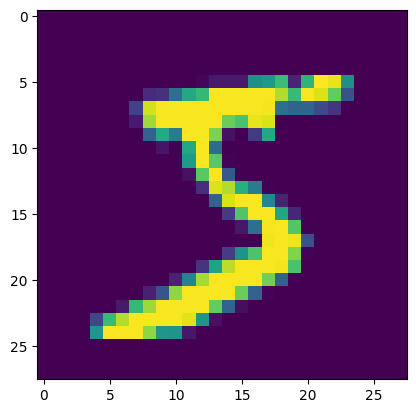

In [3]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print(y_train[0])

In [4]:
# тензор трехмерной размерности
x_train.shape, x_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
# меняем размерность для удобства обучения кучами
x_train=x_train.reshape([-1,28*28])
x_test=x_test.reshape([-1,28*28])
x_train.shape, x_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [6]:
class MNISTnet(t.nn.Module):
  def __init__(self, hidden_neurons):
    super(MNISTnet,self).__init__()
    self.layer1=t.nn.Linear(28*28,hidden_neurons)
    self.act1=t.nn.Sigmoid()
    self.layer2=t.nn.Linear(hidden_neurons,10) # классификация на 10 чисел

  def forward(self,study_tensor):
    study_tensor=self.layer1(study_tensor)
    study_tensor=self.act1(study_tensor)
    study_tensor=self.layer2(study_tensor)
    # для ускорения обучения не используем софтмакс
    return study_tensor

number_net=MNISTnet(100)

In [7]:
x_train.shape # 60k картинок, 784 пикселя в каждой

torch.Size([60000, 784])

In [8]:
y_train.shape # 60k цифр [0,9] для каждой картинки

torch.Size([60000])

In [9]:
# ПРОВЕРКА ГПУ
t.cuda.is_available()

True

In [10]:
!nvidia-smi

Thu Oct 30 17:56:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
device=t.device('cuda:0' if t.cuda.is_available() else 'cpu')
number_net=number_net.to(device)
x_test=x_test.to(device)
x_train=x_train.to(device)
y_test=y_test.to(device)
y_train=y_train.to(device)

In [12]:
# ф. кросс-энтропия принимает на вход выходной н.слой из forward()
f_loss=t.nn.CrossEntropyLoss() # - Ф. потерь для многоклассовой классификации
optiMethod=t.optim.Adam(number_net.parameters(),lr=0.001) # передаются все параметры н.с. (оптимизируются веса н.слоев)

loss_rates=[]
score_of_success_rates=[]

batch=100
for epoch in range(1,201):
    perm_i=np.random.permutation(len(x_train))

    for ind in range(0,len(x_train),batch):
        optiMethod.zero_grad()

        batch_indexes=perm_i[ind:ind+batch]
        x_batch=x_train[batch_indexes].to(device)
        y_batch=y_train[batch_indexes].to(device)

        prediction=number_net.forward(x_batch)

        # стохастический градиентный спуск
        loss=f_loss(prediction,y_batch)
        loss.backward()
        optiMethod.step()


    test_prediction=number_net.forward(x_test)
    loss_rates.append(f_loss(test_prediction,y_test).to('cpu').detach().numpy())

    # среднее количество угадываний
    score_of_success=(test_prediction.argmax(dim=1)==y_test).float().mean() # argmax(dim=1) проверяет у какого нейрона выход ближе всего к 1(вероятности)
    score_of_success_rates.append(score_of_success.to('cpu').detach().numpy())

    if epoch%20==0:
      print('EPOCH: ',epoch, ';  QUALITY: ',score_of_success,sep='')


EPOCH: 20;  QUALITY: tensor(0.9405, device='cuda:0')
EPOCH: 40;  QUALITY: tensor(0.9456, device='cuda:0')
EPOCH: 60;  QUALITY: tensor(0.9523, device='cuda:0')
EPOCH: 80;  QUALITY: tensor(0.9536, device='cuda:0')
EPOCH: 100;  QUALITY: tensor(0.9568, device='cuda:0')
EPOCH: 120;  QUALITY: tensor(0.9579, device='cuda:0')
EPOCH: 140;  QUALITY: tensor(0.9623, device='cuda:0')
EPOCH: 160;  QUALITY: tensor(0.9613, device='cuda:0')
EPOCH: 180;  QUALITY: tensor(0.9607, device='cuda:0')
EPOCH: 200;  QUALITY: tensor(0.9626, device='cuda:0')


Text(0, 0.5, 'коэф. потерь таргетных значений')

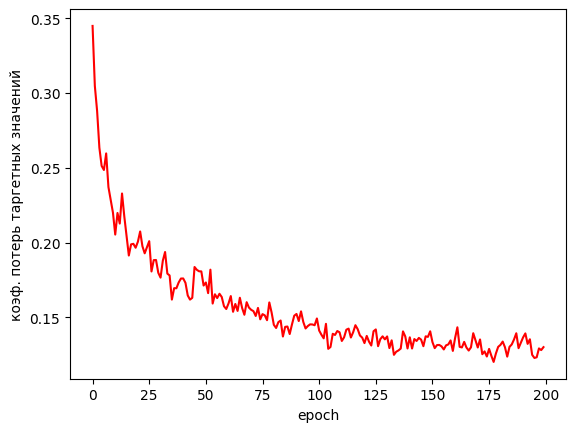

In [13]:
plt.plot(loss_rates,c='red')
plt.xlabel('epoch')
plt.ylabel('коэф. потерь таргетных значений')


Text(0.5, 0, 'epoch')

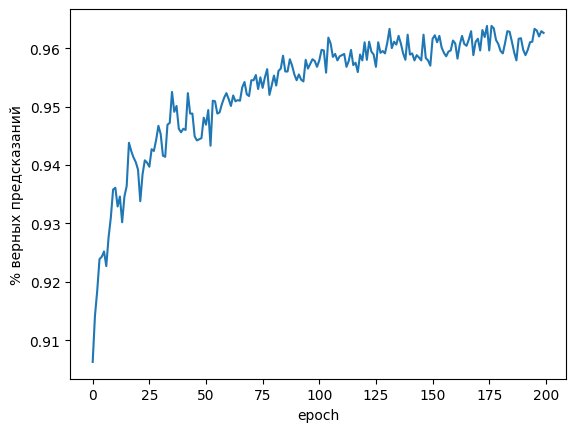

In [14]:
plt.plot(score_of_success_rates)
plt.ylabel('% верных предсказаний')
plt.xlabel('epoch')